In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, zero_one_loss, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
from Ensamble.src.AdaBoost import AdaBoost

np.random.seed(0)

## Generate data

In [3]:
def generate_data():
    X = np.random.normal(size=(12000, 10))
    y = (np.sum(X ** 2, axis=1) > np.median(np.random.chisquare(df=10, size=10000))).astype(int)
    y[y == 0] = -1

    X_train, X_test = X[:2000], X[2000:]
    y_train, y_test = y[:2000], y[2000:]
    return X_train, X_test, y_train, y_test

## Try different max_depth decision trees for AdaBoost

In [4]:
def fit_predict_repeat(model, repeat=5, xgboost=False):
    acc = 0
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = generate_data()
        if xgboost:
            y_train = np.where(y_train == -1, 0, 1)
            y_test = np.where(y_test == -1, 0, 1)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc += accuracy_score(y_test, preds)
    return acc / repeat

In [5]:
mean_accs = []
for i in range(1, 11):
    model = AdaBoost(base_learner=DecisionTreeClassifier(max_depth=i), n_classifiers=50)
    mean_acc = fit_predict_repeat(model)
    mean_accs.append(mean_acc)
    print(f"Max depth {i} Mean Accuracy: {mean_acc:.4f}")


Max depth 1 Mean Accuracy: 0.8097
Max depth 2 Mean Accuracy: 0.8817
Max depth 3 Mean Accuracy: 0.9090
Max depth 4 Mean Accuracy: 0.9115
Max depth 5 Mean Accuracy: 0.9107
Max depth 6 Mean Accuracy: 0.9009
Max depth 7 Mean Accuracy: 0.8960
Max depth 8 Mean Accuracy: 0.8839
Max depth 9 Mean Accuracy: 0.8812
Max depth 10 Mean Accuracy: 0.8780


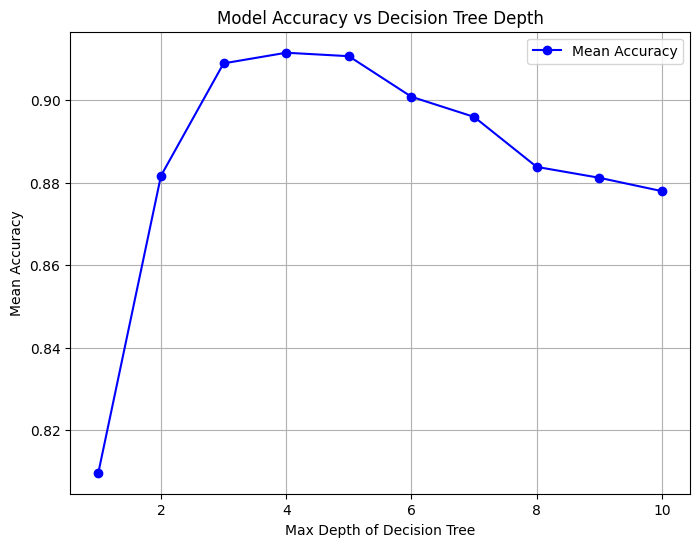

In [6]:
depths = list(range(1, 11))
plt.figure(figsize=(8, 6))
plt.plot(depths, mean_accs, marker='o', linestyle='-', color='blue', label="Mean Accuracy")
plt.xlabel("Max Depth of Decision Tree")
plt.ylabel("Mean Accuracy")
plt.title("Model Accuracy vs Decision Tree Depth")
plt.legend()
plt.grid(True)
plt.show()

## Try different number of classifiers for AdaBoost

In [7]:
mean_accs = []
for i in range(1, 11):
    model = AdaBoost(base_learner=DecisionTreeClassifier(max_depth=4), n_classifiers=i * 10)
    mean_acc = fit_predict_repeat(model, repeat=3)
    mean_accs.append(mean_acc)
    print(f"Number of clsf {i*10} Mean Accuracy: {mean_acc:.4f}")


Number of clsf 10 Mean Accuracy: 0.8174
Number of clsf 20 Mean Accuracy: 0.8698
Number of clsf 30 Mean Accuracy: 0.8850
Number of clsf 40 Mean Accuracy: 0.8950
Number of clsf 50 Mean Accuracy: 0.9068
Number of clsf 60 Mean Accuracy: 0.9086
Number of clsf 70 Mean Accuracy: 0.9115
Number of clsf 80 Mean Accuracy: 0.9134
Number of clsf 90 Mean Accuracy: 0.9170
Number of clsf 100 Mean Accuracy: 0.9178


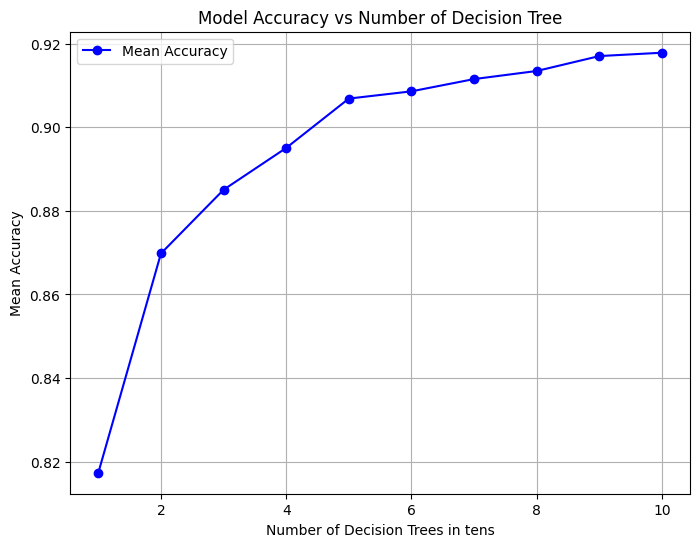

In [8]:
num_clsf = list(range(1, 11))
plt.figure(figsize=(8, 6))
plt.plot(num_clsf, mean_accs, marker='o', linestyle='-', color='blue', label="Mean Accuracy")
plt.xlabel("Number of Decision Trees in tens")
plt.ylabel("Mean Accuracy")
plt.title("Model Accuracy vs Number of Decision Tree")
plt.legend()
plt.grid(True)
plt.show()

# Compare ensembles

In [9]:
models = {
    "Single Tree": DecisionTreeClassifier(),
    "Bagging": BaggingClassifier(n_estimators=50),
    "Random Forest": RandomForestClassifier(n_estimators=50),

    "AdaBoost": AdaBoost(base_learner=DecisionTreeClassifier(max_depth=4), n_classifiers=50),
    "XGBoost": XGBClassifier(n_estimators=50, eval_metric='logloss')
}

In [10]:
for name, model in models.items():
    mean_acc = fit_predict_repeat(model, xgboost=name == "XGBoost")
    print(f"{name} Mean Accuracy: {mean_acc:.4f}")


Single Tree Mean Accuracy: 0.7427
Bagging Mean Accuracy: 0.8482
Random Forest Mean Accuracy: 0.8538
AdaBoost Mean Accuracy: 0.9160
XGBoost Mean Accuracy: 0.8723


## Plot errors for n_estimators

In [11]:
def evaluate_over_iterations(model_factory, X_train, y_train, X_test, y_test, n_estimators=80):
    errors = []
    for n in range(1, n_estimators + 1):
        model = model_factory(n)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = zero_one_loss(y_test, preds)
        errors.append(error)
    return errors

In [12]:
def adaboost_factory(n):
    return AdaBoost(n_classifiers=n)


def bagging_factory(n):
    return BaggingClassifier(n_estimators=n)


def rf_factory(n):
    return RandomForestClassifier(n_estimators=n)


def xgboost_factory(n):
    return XGBClassifier(n_estimators=n, eval_metric='logloss')

In [13]:
models_f = {
    'Bagging': bagging_factory,
    'Random Forest': rf_factory,
    'XGBoost': xgboost_factory,
    'AdaBoost': adaboost_factory
}

In [14]:
error_results = {}
X_train, X_test, y_train, y_test = generate_data()

for name, factory in models_f.items():
    print(f"Evaluating {name}...")
    if name == "XGBoost":
        error_results[name] = evaluate_over_iterations(factory, X_train, np.where(y_train == -1, 0, 1), X_test,
                                                       np.where(y_test == -1, 0, 1))
        continue
    error_results[name] = evaluate_over_iterations(factory, X_train, y_train, X_test, y_test)

Evaluating Bagging...
Evaluating Random Forest...
Evaluating XGBoost...
Evaluating AdaBoost...


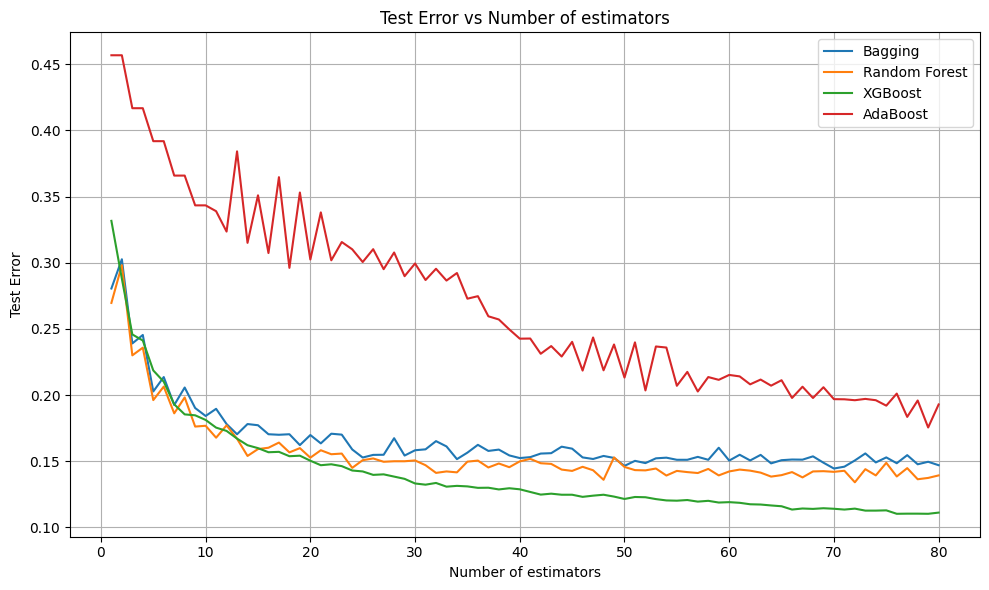

In [15]:
plt.figure(figsize=(10, 6))
for label, errors in error_results.items():
    plt.plot(range(1, len(errors) + 1), errors, label=label)
plt.xlabel('Number of estimators')
plt.ylabel('Test Error')
plt.title('Test Error vs Number of estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Real data - wine

In [16]:
models = {
    "Single Tree": DecisionTreeClassifier(),
    "Bagging": BaggingClassifier(n_estimators=50),
    "Random Forest": RandomForestClassifier(n_estimators=50),

    "AdaBoost": AdaBoost(base_learner=DecisionTreeClassifier(max_depth=4), n_classifiers=50),
    "XGBoost": XGBClassifier(n_estimators=50, eval_metric='logloss')
}

In [17]:
from BayesianClassification.src.utils.Dataset import Dataset  # from first graded labs

X, y = Dataset.load_data(44091)

y = np.where(y, 1, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
for name, model in models.items():
    if name == "XGBoost":
        model.fit(X_train, np.where(y_train == -1, 0, 1))
        preds = model.predict(X_test)
        print(f"{name} Accuracy: {balanced_accuracy_score(np.where(y_test == -1, 0, 1), preds):.4f}")
        continue

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{name} Accuracy: {balanced_accuracy_score(y_test, preds):.4f}")


Single Tree Accuracy: 0.7839
Bagging Accuracy: 0.8193
Random Forest Accuracy: 0.8393
AdaBoost Accuracy: 0.7934
XGBoost Accuracy: 0.8297


In [19]:
error_results = {}

for name, factory in models_f.items():
    print(f"Evaluating {name}...")
    if name == "XGBoost":
        error_results[name] = evaluate_over_iterations(factory, X_train, np.where(y_train == -1, 0, 1), X_test,
                                                       np.where(y_test == -1, 0, 1))
        continue
    error_results[name] = evaluate_over_iterations(factory, X_train, y_train, X_test, y_test)

Evaluating Bagging...
Evaluating Random Forest...
Evaluating XGBoost...
Evaluating AdaBoost...


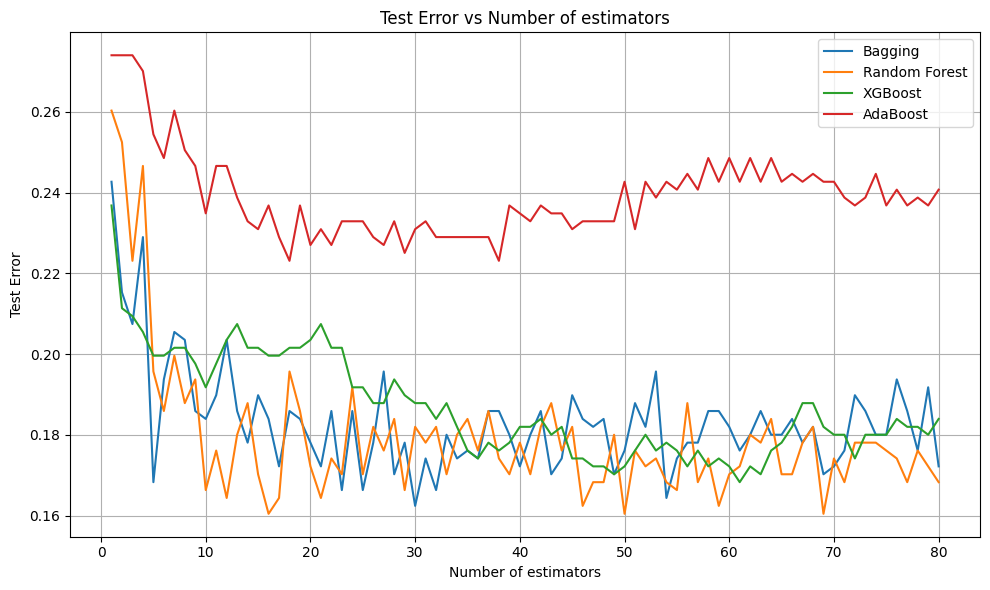

In [20]:
plt.figure(figsize=(10, 6))
for label, errors in error_results.items():
    plt.plot(range(1, len(errors) + 1), errors, label=label)
plt.xlabel('Number of estimators')
plt.ylabel('Test Error')
plt.title('Test Error vs Number of estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()